# Figure 19: Velocity components from *N*-body sims

This notebook reads the planet formation *N*-body simulation collision data and plots histograms of the velocity components. This example calculation is a Grand Tack simulation (022GTJf6hgas) from {cite}`Carter_Stewart_2022`.

In [1]:
import numpy as npy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import pkdgrav as pkd
import os
from nbodycoll import readcolllog

%config InlineBackend.figure_format = 'retina'


AU = 1.499e8 # km
TSCALE = 365.25*24.*3600. / (2.*npy.pi)  #system units to s
msun = 1.9891e33 # g
G = 6.67e-8  # cgs

maxm = 3.e-5   # maximum mass for rocky bodies (to exclude giant planets; solar masses)


simdir = './data/'
plotdir = './plots/'

correct_v = True 

In [2]:
t,sid1,sid2,m1,m2,sx1,sx2,sy1,sy2,sz1,sz2,svx1,svx2,svy1,svy2,svz1,svz2,mlr,mslr,nfrag,mfrag,m2dust=readcolllog(simdir+'ss.coll.txt')

tx = npy.where(m1>=m2,sx1,sx2)
ty = npy.where(m1>=m2,sy1,sy2)
tz = npy.where(m1>=m2,sz1,sz2)
px = npy.where(m1>=m2,sx2,sx1)
py = npy.where(m1>=m2,sy2,sy1)
pz = npy.where(m1>=m2,sz2,sz1)
tvx = npy.where(m1>=m2,svx1,svx2)
tvy = npy.where(m1>=m2,svy1,svy2)
tvz = npy.where(m1>=m2,svz1,svz2)
pvx = npy.where(m1>=m2,svx2,svx1)
pvy = npy.where(m1>=m2,svy2,svy1)
pvz = npy.where(m1>=m2,svz2,svz1)



t /= 2*npy.pi

mt = npy.where(m1>=m2,m1,m2)
mp = npy.where(m1>=m2,m2,m1)

tx = tx[mt<maxm]
ty = ty[mt<maxm]
tz = tz[mt<maxm]
px = px[mt<maxm]
py = py[mt<maxm]
pz = pz[mt<maxm]
tvx = tvx[mt<maxm]
tvy = tvy[mt<maxm]
tvz = tvz[mt<maxm]
pvx = pvx[mt<maxm]
pvy = pvy[mt<maxm]
pvz =pvz[mt<maxm]

t = t[mt<maxm]
mp = mp[mt<maxm]
mt = mt[mt<maxm]


# approx cartesian coords of collision
x = (tx + px) / 2.
y = (ty + py) / 2.
z = (tz + pz) / 2.

# cartesian relative velocity components
dvx = ( pvx - tvx ) * AU/TSCALE
dvy = ( pvy - tvy ) * AU/TSCALE
dvz = ( pvz - tvz ) * AU/TSCALE

# impact velocity magnitude
dv = npy.sqrt( dvx**2 + dvy**2 + dvz**2 )

In [3]:
# velocity correction

# Correct velocities to realistic densities? (correct for expansion factor)
real_rho = 2.
sim_rho = 2.
expfac = 6.

if correct_v:
    infl_rho = sim_rho/(expfac**3)
    rt=npy.power((3*msun*mt/(real_rho*4*npy.pi)),(1./3.))
    rp=npy.power((3*msun*mp/(real_rho*4*npy.pi)),(1./3.))
    ve = npy.sqrt( 2*G*(mt+mp)*msun / (rt+rp) )
    correctedv = npy.sqrt( (dv*1.e5)*(dv*1.e5) + (1-(infl_rho/real_rho))*ve*ve ) / 1.e5    
    
    dvx *= correctedv/dv
    dvy *= correctedv/dv
    dvz *= correctedv/dv
    dv *= correctedv/dv

In [4]:
# convert to cyclindrical coords

tr = npy.sqrt(tx**2 + ty**2)   # target radial coordinate
tphi = npy.arctan2(ty,tx)      # target azimuthal coordinate
pr = npy.sqrt(px**2 + py**2)   # proj radial coordinate
pphi = npy.arctan2(py,px)      # proj azimuthal coordinate
    
tvr = tvx*npy.cos(tphi) + tvy*npy.sin(tphi)           # targ radial velocity
tvphi = ( -tvx*npy.sin(tphi) + tvy*npy.cos(tphi) )    # targ az velocity
pvr = pvx*npy.cos(pphi) + pvy*npy.sin(pphi)           # proj radial velocity
pvphi = ( -pvx*npy.sin(pphi) + pvy*npy.cos(pphi) )    # proj az velocity

# convert to km/s
tvr *= AU/TSCALE
tvphi *= AU/TSCALE
tvz *= AU/TSCALE

pvr *= AU/TSCALE
pvphi *= AU/TSCALE
pvz *= AU/TSCALE


r = npy.sqrt(x**2 + y**2) * AU
v_kep = npy.sqrt( G*msun / (r*1.e5 ) ) / 1.e5    # Keplerian velocity at radial location of collision (km/s)

phi = npy.arctan2(y*AU,x*AU)
dvr = dvx*npy.cos(phi) + dvy*npy.sin(phi)        # relative radial velocity
dvphi = ( -dvx*npy.sin(phi) + dvy*npy.cos(phi) ) # relative azimuthal velocity

dvrel = npy.sqrt( dvphi**2 + dvr**2 + dvz**2 )   # overall magnitude of impact velocity

tvrel = npy.sqrt( (tvphi-v_kep)**2 + tvr**2 + tvz**2)  # magntiude of target velocity relative to Keplerian orbit (gas)
# sub-Keplerian motion of gas is negligibly different

N_coll: 129946


KeyboardInterrupt: 

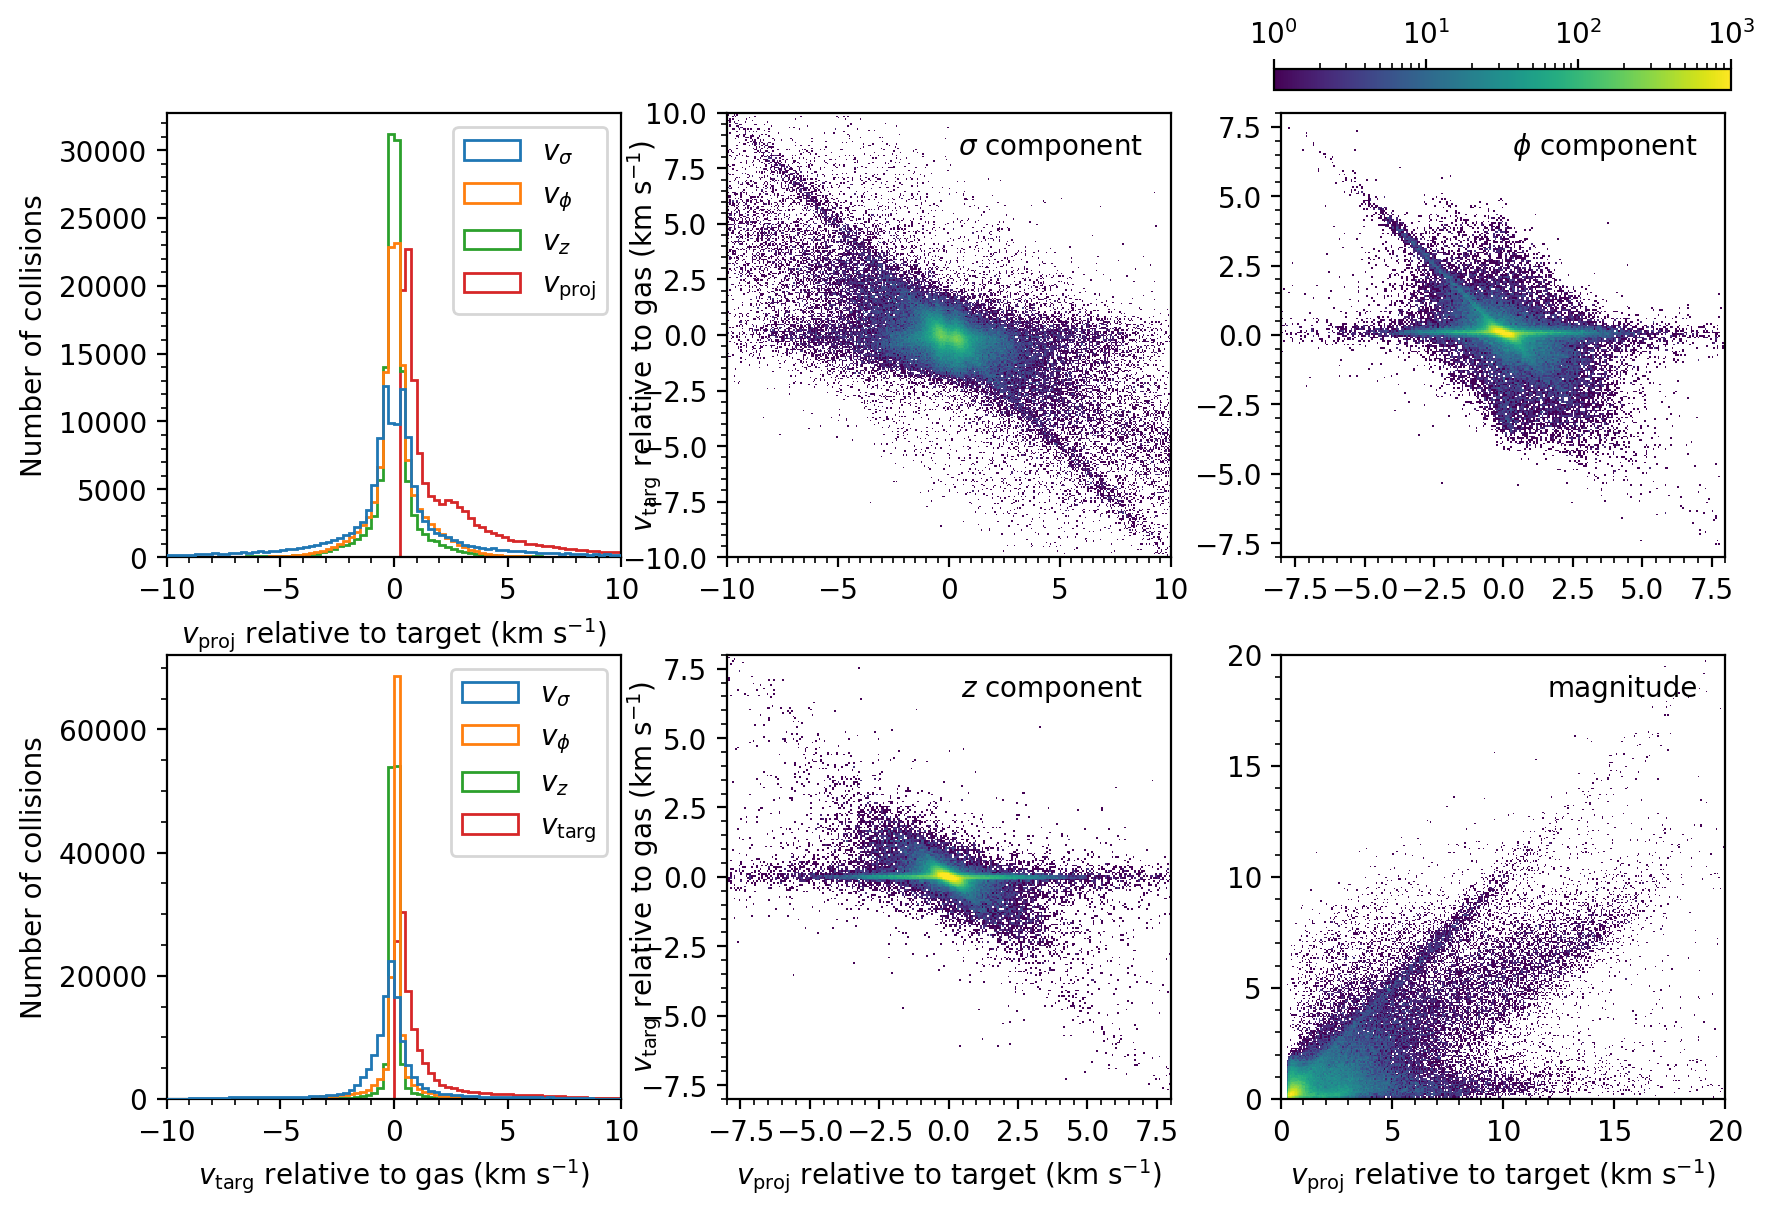

In [5]:
vbin = npy.linspace(-30,30,241)    # velocity bins for 1D histogram plots
vbin2 = npy.linspace (-30,30,961)  # velocity bins for 2D histograms

# limits for number of collisions per bin color scale
cmin=1
cmax=1000


# All:
cond = t >= 0. 
#cond = t < 50000.

# Tisserand wings and mean motion resonances:
#cond = npy.logical_and( t < 55600., 
#                       npy.logical_and( npy.logical_or(ta>1.5,pa>1.5), 
#                                       npy.logical_or(te>0.1,pe>0.1) ) )

# Wall:
#cond = npy.logical_and( npy.logical_and(t > 55600., t < 58400.), 
#cond = npy.logical_and( npy.logical_and(t > 55600., t < 72300.), 
#                       npy.logical_and( npy.logical_or(npy.logical_and(ta>1.0, ta < aJ), 
#                                          npy.logical_and(pa>1.0, ta < aJ)), 
#                                    npy.logical_or(te>0.1,pe>0.1) ) )

# Outward migration inner:
#cond = npy.logical_and( npy.logical_and(t > 58400., t < 68000.), 
#cond = npy.logical_and( npy.logical_and(t > 72300., t < 150000.), 
#                       npy.logical_and( npy.logical_or(ta<1.5,pa<1.5), 
#                                       npy.logical_or(te>0.1,pe>0.1) ) )

# Post migration high-e:
#cond = npy.logical_and( t > 68000., 
#cond = npy.logical_and( t > 150000., 
#                       npy.logical_and( npy.logical_or(ta<1.2,pa<1.2), 
#                                       npy.logical_or(te>0.1,pe>0.1) ) )


print ('N_coll:', len(t[cond]))


fig=plt.figure(figsize=(8.5,5.8))

plt.subplot(231)
plt.minorticks_on()
plt.hist(dvr[cond],bins=vbin,histtype='step',lw=1.,zorder=3,label='$v_\sigma$')
plt.hist(dvphi[cond],bins=vbin,histtype='step',lw=1.,zorder=2,label='$v_\phi$')
plt.hist(dvz[cond],bins=vbin,histtype='step',lw=1.,zorder=1,label='$v_z$')
plt.hist(dvrel[cond],histtype='step',lw=1.,bins=vbin,label='$v_\mathrm{proj}$',zorder=0)
plt.xlabel('$v_\mathrm{proj}$ relative to target (km s$^{-1}$)')
plt.ylabel('Number of collisions')
ll=plt.legend()
ll.set_zorder(-2)
plt.gca().set_rasterization_zorder(-1)
plt.xlim(-10,10)


plt.subplot(234)
plt.minorticks_on()
plt.hist(tvr[cond],bins=vbin,histtype='step',lw=1.,zorder=3,label='$v_\sigma$')
plt.hist(tvphi[cond]-v_kep[cond],bins=vbin,histtype='step',lw=1.,zorder=2,label='$v_\phi$')
plt.hist(tvz[cond],histtype='step',lw=1.,bins=vbin,zorder=1,label='$v_z$')
plt.hist(tvrel[cond],histtype='step',lw=1.,bins=vbin,label='$v_\mathrm{targ}$',zorder=0)
plt.xlabel('$v_\mathrm{targ}$ relative to gas (km s$^{-1}$)')
plt.ylabel('Number of collisions')
ll=plt.legend()
ll.set_zorder(-2)
plt.gca().set_rasterization_zorder(-1)
plt.xlim(-10,10)


plt.subplot(232,aspect='equal')
plt.minorticks_on()
h2=plt.hist2d(dvr[cond],tvr[cond],bins=vbin2,norm=LogNorm())
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.text(8.75,8.125,'$\sigma$ component',ha='right',rasterized=True)
plt.clim(cmin,cmax)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2.5))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.ylabel('$v_\mathrm{targ}$ relative to gas (km s$^{-1}$)')
plt.gca().yaxis.set_label_coords(-0.14,0.5)


plt.subplot(233,aspect='equal')
plt.minorticks_on()
h1=plt.hist2d(dvphi[cond],(tvphi-v_kep)[cond],bins=vbin2,norm=LogNorm())
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.text(7,6.5,'$\phi$ component',ha='right',rasterized=True)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2.5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2.5))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax=plt.gca()
plt.clim(cmin,cmax)


plt.subplot(235,aspect='equal')
plt.minorticks_on()
h3=plt.hist2d(dvz[cond],tvz[cond],bins=vbin2,norm=LogNorm())
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.text(7,6.5,'$z$ component',ha='right')
plt.xlabel('$v_\mathrm{proj}$ relative to target (km s$^{-1}$)')
plt.ylabel('$v_\mathrm{targ}$ relative to gas (km s$^{-1}$)')
plt.gca().yaxis.set_label_coords(-0.14,0.5)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2.5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2.5))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.clim(cmin,cmax)


plt.subplot(236,aspect='equal')
plt.minorticks_on()
h4=plt.hist2d(dvrel[cond],tvrel[cond],bins=vbin2,norm=LogNorm())
plt.xlim(0,20)
plt.ylim(0,20)
plt.text(18.75,18.125,'magnitude',ha='right')
plt.xlabel('$v_\mathrm{proj}$ relative to target (km s$^{-1}$)')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.clim(cmin,cmax)


cax = fig.add_axes([0.7212, 0.94, 0.2688, 0.018])
cb = fig.colorbar(h2[3], cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.subplots_adjust(hspace=0.22,wspace=0.22,left=0.07,right=0.99,top=0.92,bottom=0.07)

plt.savefig(plotdir+'Fig19-rel_v_hist_022GTJf6hydrogas.pdf',dpi=1200,pad_inches=0.1,bbox_inches='tight')
plt.savefig(plotdir+'Fig19-rel_v_hist_022GTJf6hydrogas.png',dpi=1200,pad_inches=0.1,bbox_inches='tight')
plt.show()



In most collisions one of the impactors is on a low excitation orbit, while the other is excited. Velocity of the target
with respect to the nebular gas, and the projectile with respect to the target for collisions in the simulation from Fig. 1 (run 022GTJf6hgas from {cite}`Carter_Stewart_2022`). The left two panels show histograms for the target and projectile velocities, while the right four panels show 2D histograms for the velocity of target and projectile, where the color scale indicates the number of impacts in each bin. The azimuthal, radial and vertical velocity components are shown, as well as the overall magnitude.
Collision velocity components mostly fall into two distinct bands: the horizontal band indicates that the target is moving on
approximately a circular orbit similar to the nebular gas, while the projectile is on an excited orbit; the band with a slope
of approximately −1 indicates collisions in which the target is excited while the projectile has almost the opposite motion,
corresponding to an orbit similar to the gas. Outside of these bands both target and projectile are on excited orbits, with the
distributions being determined by the dynamics of the giant planets. In the magnitude panel these bands become horizontal
and +1 sloped.